In [1]:
import torch
from torch import nn
from torch.nn import ReLU
from torch.nn import Module
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from loss import LossFunc
from utils import *

In [2]:
# khởi tạo các hyper parameters
config = {
    'S':7,
    'B':2,
    'C':4,
    'LEARNING_RATE': 2e-5,
    'DEVICE': 'cuda' if torch.cuda.is_available() else 'cpu',
    'EPOCHS': 10,
    'ROOT_DIR':'data/'
}

# Xây dụng mô hình

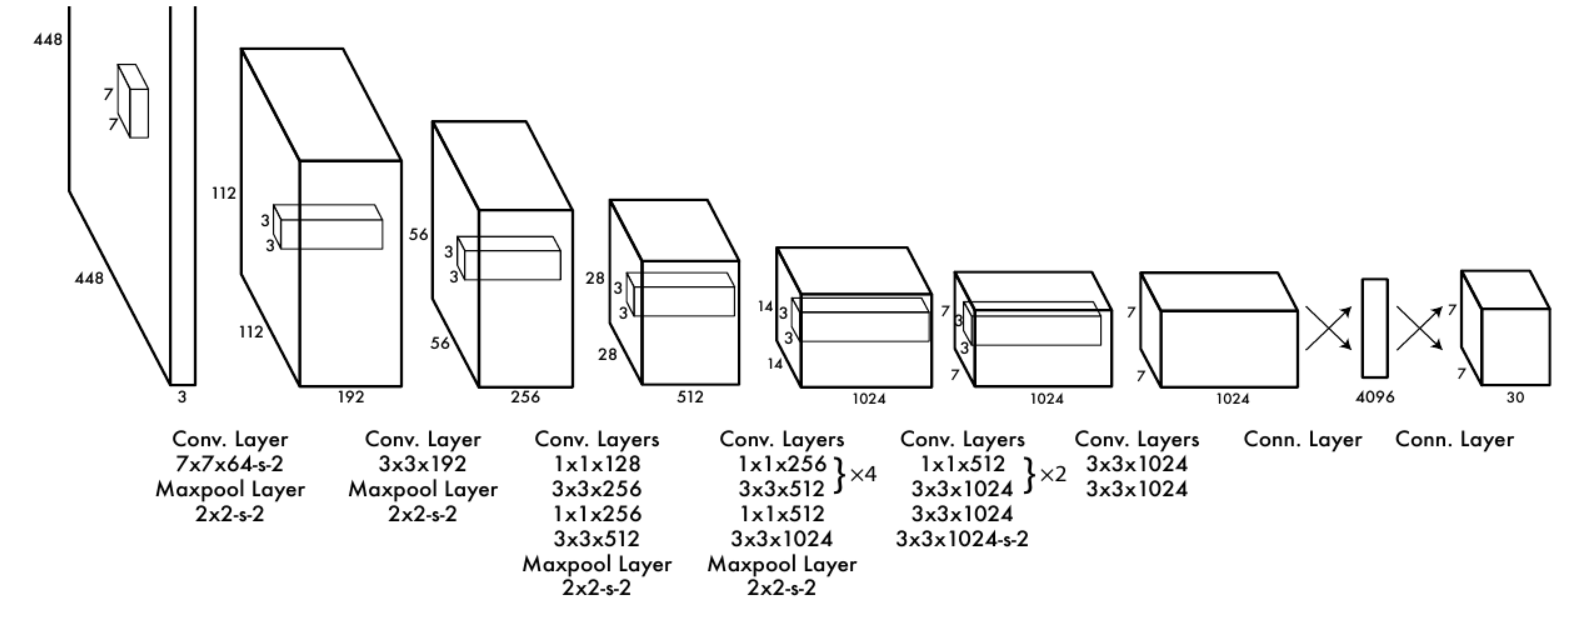

Trong tutorial này mình sẽ tạo 1 list để lưu trữ các convolutional layers của mô hình (thuận tiện hơn trong việc cấu hình). 
Mỗi phần tử trong list tương ứng với một convolutional layer

In [3]:
architecture_setting = [
    # (kernel size, number_filtes, stride, padding)
    (7, 64, 2, 3),
    "Maxpooling",
    (3, 192, 1, 1),
    "Maxpolling",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "Maxpooling",
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "Maxpooling",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1), 
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]

## Xây dựng Convolutional Block

In [4]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias = False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels) # Các bạn nên đọc về kỹ thuật batch normalize
        self.ReLU = ReLU() # lựa chọn hàm kích hoạt trên mỗi unit
    def forward(self, x):
        return self.ReLU(self.batchnorm(self.conv(x)))

In [5]:
cnn = CNNBlock(3, 64, kernel_size=7, stride=2, padding=3)
print(cnn)

CNNBlock(
  (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ReLU): ReLU()
)


# Class Yolov1

In [6]:
class Yolov1(Module):
    def __init__(self, in_channels=3, **kwargs):
        super(Yolov1, self).__init__()
        self.architecture = architecture_setting
        self.in_channels = in_channels
        self.conv_net = self.create_conv_net()
        self.full_connected = self.create_full_connected(**kwargs)

    def create_conv_net(self):
        # Hàm này dùng để khởi tạo các concolutional layers bằng cách duyệt qua các phần tử trong architecture setting (24 convolutional layers)
        layers = []
        in_channels = self.in_channels
        for layer in self.architecture:
            if isinstance(layer, tuple):
                layers += [CNNBlock(in_channels, layer[1], kernel_size=layer[0], stride=layer[2], padding=layer[3])]
                in_channels = layer[1] # OUTPUT của layer này sẽ là INPUT của layer kế tiếp
            elif isinstance(layer, str):
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            elif isinstance(layer, list):
                # cài đặt repeated layers
                layer1 = layer[0]
                layer2 = layer[1]
                num_repeat = layer[2]
                for repeat in range(num_repeat):
                    layers += [CNNBlock(in_channels, layer1[1],  kernel_size=layer1[0], stride=layer1[2], padding=layer1[3])]
                    layers += [CNNBlock(layer1[1], layer2[1],  kernel_size=layer2[0], stride=layer2[2], padding=layer2[3])]
                in_channels = layer2[1]
        return nn.Sequential(*layers)
    
    def create_full_connected(self, S, B, C):
        # Hàm này dùng để khở tạo các fully connected layers (có tổng cộng 2 fully connected layers)
        return nn.Sequential(nn.Flatten(), 
                             nn.Linear(1024*S*S, 4096),
                             nn.Dropout(0.5),  # Mọi người có thể đọc thêm về kỹ thuật drop out neural
                             nn.ReLU(),
                             nn.Linear(4096, S*S*(C+B*5)) # một ảnh được chia thành SxS cells
                                                          # mỗi cell dự đoán B bounding box 
                                                          # Một bouding box chỉ dự đoán 1 class của đối tượng (class được biểu diễn dạng one-hot)
                                                          # một bounding gồn 5 chỉ số (pc - (probable confidence), x, y - (tọa độ tâm), w,h (chiều rộng, chiều cao của box))
                             )
    def forward(self, x):
        x = self.conv_net(x)
        return self.full_connected(torch.flatten(x, start_dim=1))

# Intersection Over Union

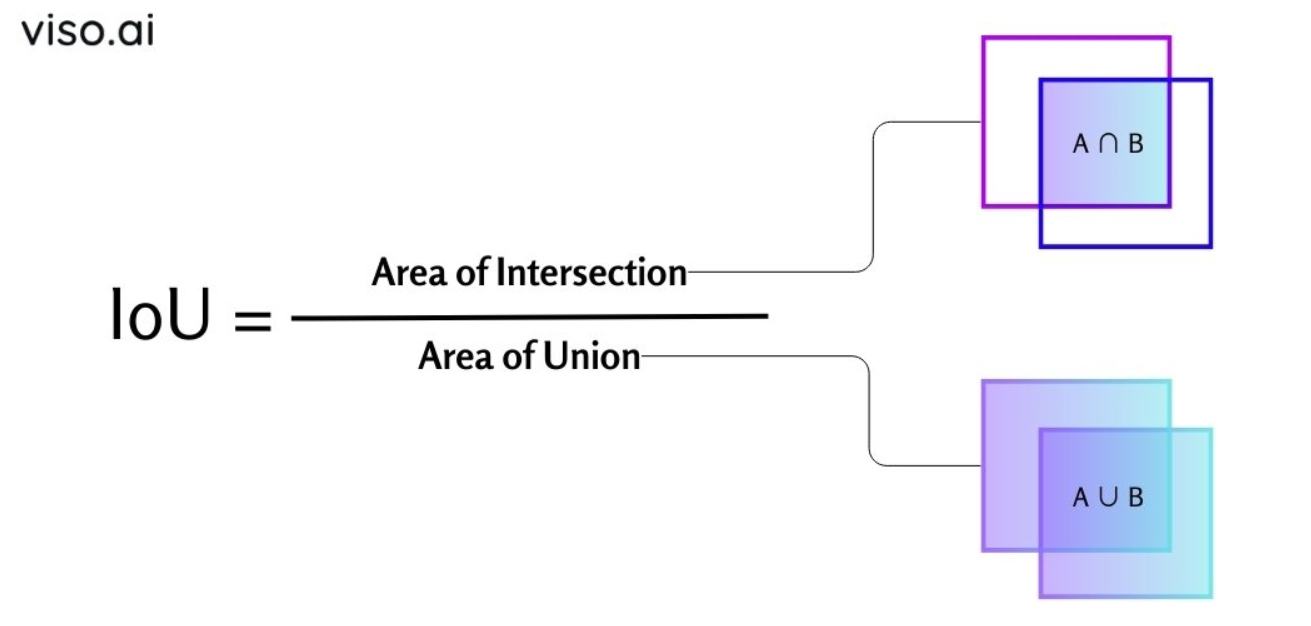

In [7]:

def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]  # (N, 1)
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

# Loss Function

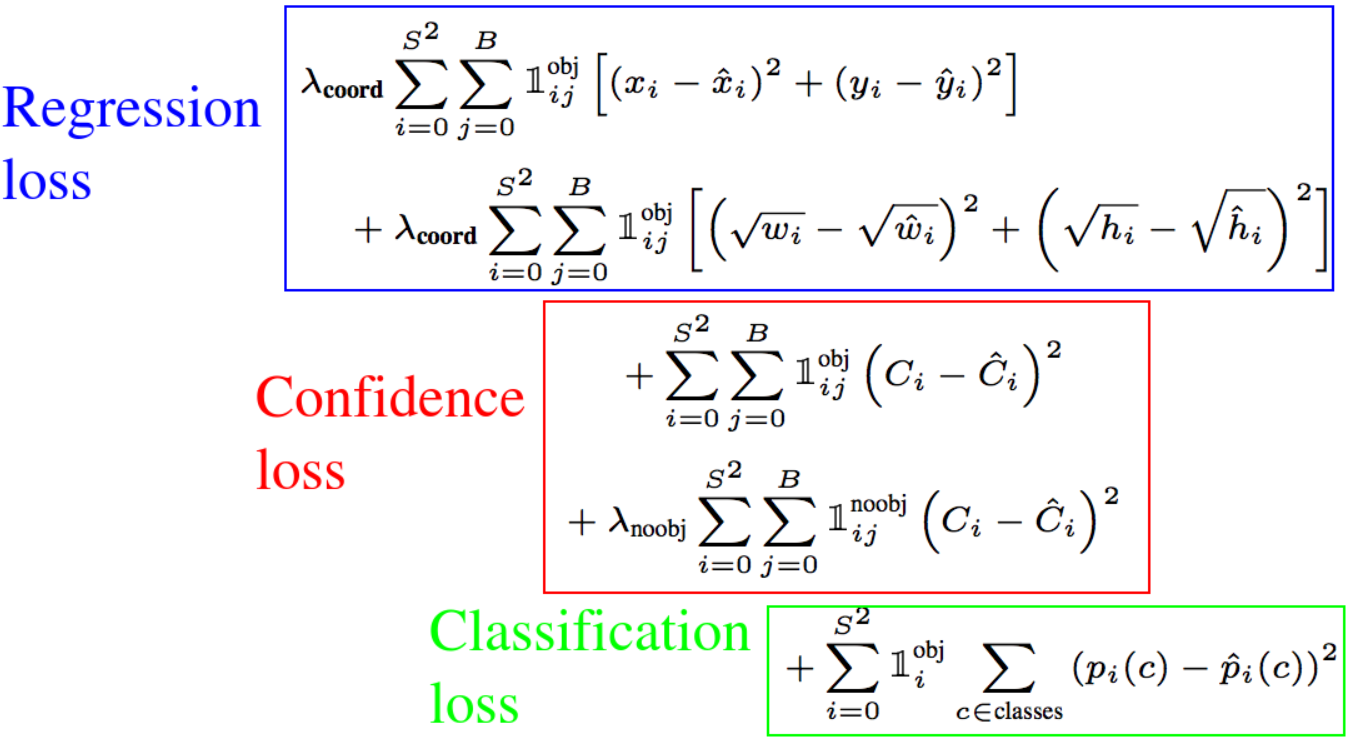

In [8]:
class LossFunc(nn.Module):
    def __init__(self, S, B, C):
        super(LossFunc, self).__init__()
        self.lambda_noobj = 0.5
        self.lambda_coord = 5
        self.S = S 
        self.B = B # số lượng bounding box mà mỗi cell dự đoán
        self.C = C # số lượng class
        self.mse = nn.MSELoss(reduction='sum')

    def forward(self, predictions, target):
        predictions = predictions.reshape(-1, self.S, self.S, self.C+self.B*5) 
        print(predictions.shape)
        print(target.shape)
        iou_b1 = intersection_over_union(predictions[...,self.C+1:self.C+5], target[...,self.C+1:self.C+5]) # mục đích là cắt lấy 4 chỉ số (x,y,w,h) giúp ta xác định box
        iou_b2 = intersection_over_union(predictions[...,self.C+6:self.C+10], target[...,self.C+6:self.C+10]) # làm tương tự với bounding box thứ 2 (do mỗi cell dự đoán 2 box -> ta cần tính iou của cả 2 để thực hiện so sánh)
        ious = torch.cat([iou_b1.squeeze(0), iou_b2.squeeze(0)], dim=0)
        max_iou, max_box_index = torch.max(ious, dim=0) #chọn ra bouding box có iou lớn nhất
        exist_box = target[...,self.C].unsqueeze(3)
        # REGRESSION LOSS (BOX LOSS)
        box_target = exist_box*target[..., self.C+1:self.C+5]

        box_prediction = exist_box * ((1-max_box_index) * predictions[...,self.C+1:self.C+5] + max_box_index * (predictions[...,self.C+6:self.C+10]))
        box_prediction[...,2:4] = torch.sign(box_prediction[...,2:4]) * torch.sqrt(torch.abs(box_prediction[...,2:4]+ 1e-10))  

        box_loss = self.mse(torch.flatten(box_prediction,end_dim=-2), torch.flatten(box_target, end_dim=-2))
        # Confidence Loss
        # OBJECT LOSS
        probable_prediction = exist_box * ((1-max_box_index) * predictions[...,self.C]+ max_box_index * (predictions[...,self.C+5]))
        object_loss = self.mse(torch.flatten(exist_box*probable_prediction[...,self.C]), torch.flatten(exist_box*target[...,self.C]))
        # NO OBJECT LOSS
        no_object_loss = self.mse(
            torch.flatten((1-exist_box)*predictions[..., self.C], start_dim=1), 
            torch.flatten((1-exist_box)*target[...,self.C],start_dim=1)) 
        + self.mse(
            torch.flatten((1-exist_box)*predictions[..., self.C+5], start_dim=1), 
            torch.flatten((1-exist_box)*target[...,self.C+5],start_dim=1))
        # CLASS LOSS
        class_loss = self.mse(
            torch.flatten(exist_box*predictions[...,:self.C],end_dim=-2),
            torch.flatten(exist_box*target[...,:self.C],end_dim=-2))
        # TOTAL LOSS 
        print(f'box_loss: {box_loss}')
        print(f'object loss: {object_loss}')
        print(f'no_object_loss: {no_object_loss}')
        print(f'class_loss: {class_loss}')
        loss = self.lambda_coord * box_loss + object_loss + self.lambda_noobj*no_object_loss + class_loss
        return loss

# Chuẩn bị dữ liệu

Mục đích của tutorial này nhằm giúp mọi người hiểu về cách thức hoạt động của model, vậy nên mình sẽ không chú trọng vào việc training. 

Mình chỉ sử dụng duy nhất 1 ảnh và 1 nhãn tương ứng để feedforward một lần duy nhất sau đó tính toán loss

In [9]:
# Đọc và chuyển đổi file label về dạng ma trận, giúp tính toán loss sau mỗi lần feedforward
boxes = []
with open('data/cam_01_00004.txt') as f:
    for line in f.readlines():
        cls, x, y, w, h = [float(item) if float(item)!=int(float(item)) else int(item) for item in line.replace('\n','').split()]
        boxes.append([cls, x, y, w, h])
# boxes = torch.tensor(boxes)
label_matrix = np.zeros((config['S'],config['S'], config['C']+config['B']*5))
for box in boxes: 
    cls, x, y, w, h = box
    col, row = int(config['S']*y), int(config['S']*x)
    one_hot_cls = [0 for _ in range(config['C'])]
    one_hot_cls[cls] = 1
    label_matrix[row, col] = *one_hot_cls, 1, x, y, w, h, 1, x, y, w, h
label_matrix = torch.tensor(label_matrix).unsqueeze(0)
print(label_matrix.shape)

torch.Size([1, 7, 7, 14])


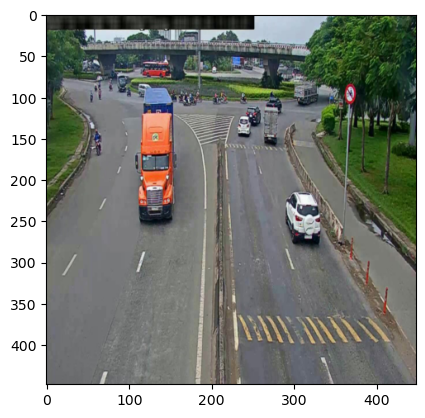

In [10]:
# Đọc ảnh sau đó resize về kích thước tiêu chuẩn của model
img = Image.open('data/cam_01_00004.jpg')
transform = transforms.Resize((448,448))
img = transform(img)
plt.imshow(img)


In [11]:
totensor = transforms.ToTensor()
img_tensor = totensor(img)
print(img_tensor.size())
img_tensor = img_tensor.unsqueeze(0) # thông thường ở dim=0 của tensor train sẽ là batchsize = (2,4,8,...) nhưng do ở đây mình chỉ dùng 1 ảnh nên batchsize=1 
img_tensor.shape

torch.Size([3, 448, 448])


torch.Size([1, 3, 448, 448])

In [12]:
model = Yolov1(S=config['S'], B=config['B'], C=config['C'])
optimizer = torch.optim.Adam(model.parameters(), lr=config['LEARNING_RATE'], weight_decay=0.1)
loss = LossFunc(config['S'], config['B'], config['C'])
img_tensor, label_matrix = img_tensor.to(config['DEVICE']), label_matrix.to(config['DEVICE'])
out = model(img_tensor) # output sau khi feedforward 
loss = loss(out, label_matrix)
print(f'Toal loss :{loss.item()}')

torch.Size([1, 7, 7, 14])
torch.Size([1, 7, 7, 14])
box_loss: 8.052796752658498
object loss: 10.101811049337094
no_object_loss: 72.09414334312821
class_loss: 9.582117151591895
Toal loss :95.99498363578559
